<a href="https://colab.research.google.com/github/vincentqb/audio-tutorial/blob/master/Audio_Command_Classification_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch


In [2]:
!pip install torchaudio

Audio Command Classifier with torchaudio
========================================

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset. First, let’s
import the common torch packages such as `torchaudio <https://github.com/pytorch/audio>`_
and can be installed by following the
instructions on the website.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd

Let’s check if a CUDA GPU is available and select our device. Running the network on a GPU will greatly decrease the training/testing runtime.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use SpeechCommands, which is a datasets of 35 commands spoken by different people. The dataset ``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the dataset.

The actual loading and formatting steps happen in the access function ``__getitem__``. In ``__getitem__``, we use ``torchaudio.load()`` to convert the audio files to tensors. ``torchaudio.load()`` returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands). In this dataset, all audio files are about 1 second long (and so about 16000 time frames long).

Here we wrap it to split it into standard training, validation, testing subsets.

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        
        if subset in ["training", "validation"]:
            filepath = os.path.join(self._path, "validation_list.txt")
            with open(filepath) as f:
                validation_list = [os.path.join(self._path, l.strip()) for l in f.readlines()]

        if subset in ["training", "testing"]:
            filepath = os.path.join(self._path, "testing_list.txt")
            with open(filepath) as f:
                testing_list = [os.path.join(self._path, l.strip()) for l in f.readlines()]

        if subset == "validation":
            walker = validation_list
        elif subset == "testing":
            walker = testing_list
        elif subset in ["training", None]:
            walker = self._walker  # defined by SPEECHCOMMANDS parent class
        else:
            raise ValueError("When `subset` not None, it must take a value from {'training', 'validation', 'testing'}.")

        if subset == "training":
            walker = filter(
                lambda w: not (w in validation_list or w in testing_list), walker
            )

        self._walker = list(walker)

train_set = SubsetSC("training")
# valid_set = SubsetSC("validation")
test_set = SubsetSC("testing")
  
  
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform (the audio signal), the sample rate, the utterance (label), the ID of the speaker, the number of the utterance.

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


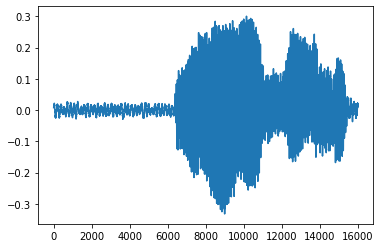

In [6]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure();
plt.plot(waveform.t().numpy());

Let's find the list of labels available in the dataset.

In [7]:
labels = list(set(datapoint[2] for datapoint in train_set))
labels

['off',
 'right',
 'backward',
 'two',
 'three',
 'wow',
 'stop',
 'on',
 'bird',
 'sheila',
 'happy',
 'forward',
 'six',
 'seven',
 'bed',
 'nine',
 'zero',
 'four',
 'marvin',
 'five',
 'cat',
 'follow',
 'yes',
 'up',
 'dog',
 'eight',
 'visual',
 'go',
 'no',
 'house',
 'tree',
 'left',
 'one',
 'learn',
 'down']

The 35 audio classes are commands that are said by users. The first few files are people saying "marvin".


In [8]:
waveform_first = train_set[0][0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [9]:
waveform_second = train_set[0][0]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying "visual".

In [10]:
waveform_last = train_set[-1][0]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

The dataset uses a single channel for audio. We do not need to down mix the audio channels (which we could do for instance by either taking the mean along the channel dimension, or simply keeping only one of the channels).

We downsample the audio for faster processing without losing too much of the classification power.



In [11]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

To encode each word, we simply return the position of the command in the list above.

In [12]:
def encode(word):
  return torch.tensor(labels.index(word))

encode("yes")

tensor(22)

We now define a collate function that assembles a list of audio recordings and a list of utterances into two batched tensors. In this function, we also apply the resampling, and the encoding. The collate function is used in the pytroch data loader that allow us to iterate over a dataset by batches.

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    # and so we are only interested in item 0 and 2

    # Apply transforms to waveforms
    tensors = [transform(b[0]) for b in batch]
    tensors = pad_sequence(tensors)
        
    # Apply transform to target utterance
    targets = [encode(b[2]) for b in batch]
    targets = torch.stack(targets)
        
    return tensors, targets

In [14]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, collate_fn=collate_fn, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = False, collate_fn=collate_fn, **kwargs)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in https://arxiv.org/pdf/1610.00087.pdf. An important aspect
of models processing raw audio data is the receptive field of their
first layer’s filters. Our model’s first filter is length 80 so when
processing audio sampled at 8kHz the receptive field is around 10ms.
This size is similar to speech processing applications that often use
receptive fields ranging from 20ms to 40ms.




In [15]:
class Net(nn.Module):
    def __init__(self, n_output=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])  # input should be 512x14 so this outputs a 512x1
        x = x.permute(0, 2, 1)  # change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

model = Net(n_output=len(labels))
model.to(device)
print(model)

Net(
  (conv1): Conv1d(1, 128, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=35, bias=T

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 571939


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training.

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps.


Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.

In [18]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        output = output.permute(1, 0, 2)  # original output dimensions are batch x 1 x n_output
        loss = F.nll_loss(output[0], target)  # the loss functions expects a batch x n_output input
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:  # print training stats
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss:.6f}')
            
        if 'pbar' in globals():
            pbar.update()

 Now that we have a training function, we need to make one for testing
 the networks accuracy. We will set the model to ``eval()`` mode and then
 run inference on the test dataset. Calling ``eval()`` sets the training
 variable in all modules in the network to false. Certain layers like
 batch normalization and dropout layers behave differently during
 training so this step is crucial for getting correct results.

In [19]:
def test(model, epoch):
    model.eval()  
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1]  # index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
        if 'pbar' in globals():
          pbar.update()
    
    print(f'\nTest set: Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

 Finally, we can train and test the network. We will train the network
 for ten epochs then reduce the learn rate and train for ten more epochs.
 The network will be tested after each epoch to see how the accuracy
 varies during the training.

In [ ]:
log_interval = 20
n_epoch = 2

with tqdm(total=n_epoch * (len(train_loader) + len(test_loader))) as pbar:
    for epoch in range(1, n_epoch+1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.556347
Train Epoch: 1 [2560/84843 (3%)]	Loss: 3.186630
Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.030628
Train Epoch: 1 [7680/84843 (9%)]	Loss: 2.927871
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.450978
Train Epoch: 1 [12800/84843 (15%)]	Loss: 2.294995
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.242920
Train Epoch: 1 [17920/84843 (21%)]	Loss: 2.452632
Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.051516
Train Epoch: 1 [23040/84843 (27%)]	Loss: 1.877660
Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.133268
Train Epoch: 1 [28160/84843 (33%)]	Loss: 1.977037
Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.862828
Train Epoch: 1 [33280/84843 (39%)]	Loss: 1.471881
Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.659306
Train Epoch: 1 [38400/84843 (45%)]	Loss: 1.564600
Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.228462
Train Epoch: 1 [43520/84843 (51%)]	Loss: 1.348768
Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.377202
Train Epoch: 1 [48640/84843 (57%)]	Loss: 1.456595
Train Epoch

Conclusion
----------

After one epoch, the network should be more than 70% accurate by.

There are also other data preprocessing methods, such as finding the mel frequency cepstral coefficients (MFCC), that can reduce the size of the dataset. This transform is also available in torchaudio as ``torchaudio.transforms.MFCC``.

In this tutorial, we used torchaudio to load a dataset and resample the signal. We have then defined a neural network that we trained to recognize a given command.